In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

class createDataset:
  def __init__(self, fileName):
    self.df = pd.read_csv(fileName)
    self.lat = np.array(self.df['Latitude'].tolist())
    self.lon = np.array(self.df['Longitude'].tolist())
    self.accel = np.array(self.df['harsh_acc'].tolist())
    self.brk = np.array(self.df['harsh_brk'].tolist())

  def createIO(self):
    latStand = createDataset.standardize(self.lat)
    lonStand = createDataset.standardize(self.lon)
    X = np.column_stack((latStand, lonStand))
    y = np.array(self.brk)

    # Split the dataset into training and testing sets
    return train_test_split(X, y, test_size=0.2, random_state=42)

  @staticmethod
  def normalize(data):
    minVal = np.min(data)
    maxVal = np.max(data)
    scaledData = (data- minVal)/(maxVal-minVal)
    return scaledData

  @staticmethod
  def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    scaledData = (data - mean)/std
    return scaledData

  @staticmethod
  def basicStatistics(data):
    mean = np.mean(np.array(data))
    std_dev = np.std(np.array(data))
    min = np.min(np.array(data))
    max = np.max(np.array(data))
    print("Mean {}, min {}, max {}, std {}".format(mean, min, max, std_dev))


dataset = createDataset('/home/harsh_events.csv')

Auxiliary functions

In [ ]:
def writeList(fname, field):
  f = open(fname, 'w')
  for fi in field:
    s1 = str(fi) +'\n'
    f.write(s1)
  f.close()

use k-means clustering to get cluster ID for each latitude, longitude

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 40
#create cluster ID using k means clustering
feature_vectors = np.column_stack((dataset.lat, dataset.lon))

# Initialize and fit KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters)  # Specify the number of clusters
kmeans.fit(feature_vectors)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Correlation Matrix

In [ ]:
alldata = np.column_stack((dataset.lat, dataset.lon, dataset.brk, dataset.accel))
print("shape of alldata {}".format(alldata.shape))
correlation_matrix = np.corrcoef(alldata, rowvar=False)

print("Correlation Matrix:")
print(correlation_matrix)

shape of alldata (4000, 4)
Correlation Matrix:
[[ 1.          0.03139863 -0.00202296  0.00202296]
 [ 0.03139863  1.          0.02668525 -0.02668525]
 [-0.00202296  0.02668525  1.         -1.        ]
 [ 0.00202296 -0.02668525 -1.          1.        ]]


visualize clusters

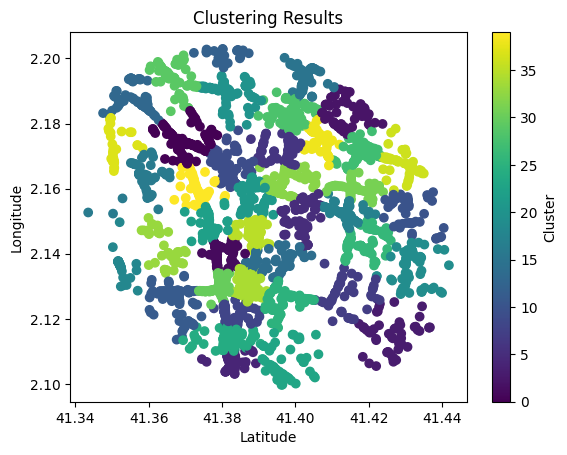

In [ ]:
import matplotlib.pyplot as plt

# Plot data points with cluster assignments
plt.scatter(dataset.lat, dataset.lon, c=cluster_labels, cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

visualize one cluster only

cluster 1: 66 points
Mean 41.41334490909091, min 41.406368, max 41.423769, std 0.004043843359101272
Mean 2.182628015151515, min 2.176307, max 2.190501, std 0.003740810666040759


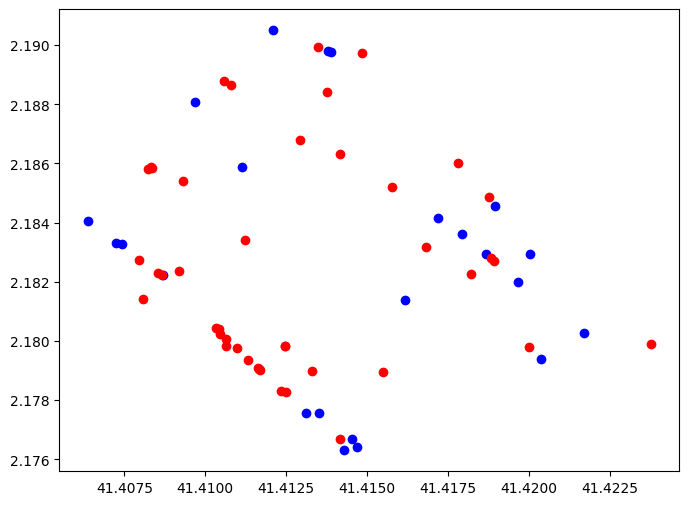

In [ ]:
ci =2 #for cluster with ID 0
location_ci = [ [lati, dataset.lon[i]] for i, lati in enumerate(dataset.lat) if cluster_labels[i]==ci  ]
brk_ci = [ brki for i, brki in enumerate(dataset.brk) if cluster_labels[i]==ci  ]
location = np.array(location_ci)

print("cluster 1: {} points".format(len(brk_ci)))
lat_c0 = location[:,0]
lon_c0 = location[:,1]
brk_c0 = np.array(brk_ci)

createDataset.basicStatistics(lat_c0)
createDataset.basicStatistics(lon_c0)

latNorm = createDataset.normalize(lat_c0)
lonNorm = createDataset.normalize(lon_c0)
latS = createDataset.standardize(lat_c0)
lonS = createDataset.standardize(lon_c0)


lat_brk0 = [ dataset.lat[i] for i in range(len(dataset.brk)) if (dataset.brk[i] == 0 and cluster_labels[i]==ci) ]
lon_brk0 = [ dataset.lon[i] for i in range(len(dataset.brk)) if (dataset.brk[i] == 0 and cluster_labels[i]==ci)  ]
lat_brk1 = [ dataset.lat[i] for i in range(len(dataset.brk)) if (dataset.brk[i] == 1 and cluster_labels[i]==ci)  ]
lon_brk1 = [ dataset.lon[i] for i in range(len(dataset.brk)) if (dataset.brk[i] == 1 and cluster_labels[i]==ci)  ]

fig2, figBrk  = plt.subplots(figsize=(8, 6))

# Plot the data points
figBrk.scatter(lat_brk0, lon_brk0, color='blue', label='braking=0')  # Blue dots for value=0
figBrk.scatter(lat_brk1, lon_brk1, color='red', label='braking=1')   # Red dots for value=1
"""
# Add labels and legend
figBrk.set_xlabel('Latitude')
figBrk.set_ylabel('Longitude')
figBrk.legend()
figBrk.set_title('Harsh Braking')

###
fig3, figBrk  = plt.subplots(figsize=(8, 6))

# Plot the data points
figBrk.scatter(lat_brk1, lon_brk1, color='red', label='braking=1')   # Red dots for value=1

# Add labels and legend
figBrk.set_xlabel('Latitude')
figBrk.set_ylabel('Longitude')
figBrk.legend()
figBrk.set_title('Harsh Braking')
"""
plt.show()

Gradient Boosting classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = dataset.createIO()

"""
#create cluster ID using k means clustering
feature_vectors = np.column_stack((lat, lon))

# Initialize and fit KMeans clustering model
kmeans = KMeans(n_clusters=4)  # Specify the number of clusters
kmeans.fit(feature_vectors)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_
"""

"""
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 5, 7, 10],
    'learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
}

# Create Random Forest classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Get the best hyperparameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best accuracy:", best_accuracy)
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
Best accuracy: 0.63475
"""

# Create Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=10, random_state=42)

# Train the Gradient Boosting classifier on the training data
gb_classifier.fit(X_train, y_train)

feature_importances = gb_classifier.feature_importances_
print("Feature importance {}".format(feature_importances))

# Predict the labels for test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the classifier's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)